<a href="https://colab.research.google.com/github/agsosin/COLAB/blob/main/Sosin_Agnieszka_ZMSI_lab7_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center>
    <font size="5"> Zaawansowane Metody Uczenia Maszynowego i Głębokiego<br/>
        <small><em>Studia stacjonarne II stopnia 2024/2025</em><br/>Kierunek: Informatyka<br>Specjalność: Systemy inteligentne i rozszerzona rzeczywistość</small>
    </font>
</center>
<br>


# Laboratorium nr 10: Autoencoders

## Montowanie Google Drive

## Import bibliotek

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
print('Numpy version:', np.__version__)
print('Tensorflow version:', tf.__version__)

Numpy version: 1.26.4
Tensorflow version: 2.18.0


## Baza MNIST

- Baza MNIST zawiera zbiór trenujący składający się z 60,000 przykładów skanów ręcznie pisanych cyfr od 0 do 9 (problem klasyfikacyjny z 10 klasami).
- Zbiór testowy zawiera 10,000 przykładów.
- Każdy obraz ma rozmiar 28x28 pikseli. Stanowią one 28 * 28 = 784 wejść do sieci.

#### Pobieranie bazy MNIST
- Bazę MNIST można pobrać bespośrednio ze strony http://yann.lecun.com/exdb/mnist/
- Najwygodniej jednak jest użyć bazy MNIST z wykorzystaniem biblioteki Keras

In [2]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
print(train_images.shape, train_labels.shape, test_images.shape, test_labels.shape)
train_images = np.expand_dims(train_images, axis=-1)/255.
train_labels = np.int64(train_labels)
test_images = np.expand_dims(test_images, axis=-1)/255.
test_labels = np.int64(test_labels)
print(train_images.shape, train_labels.shape, test_images.shape, test_labels.shape)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)
(60000, 28, 28, 1) (60000,) (10000, 28, 28, 1) (10000,)


Przykładowe cyfry:

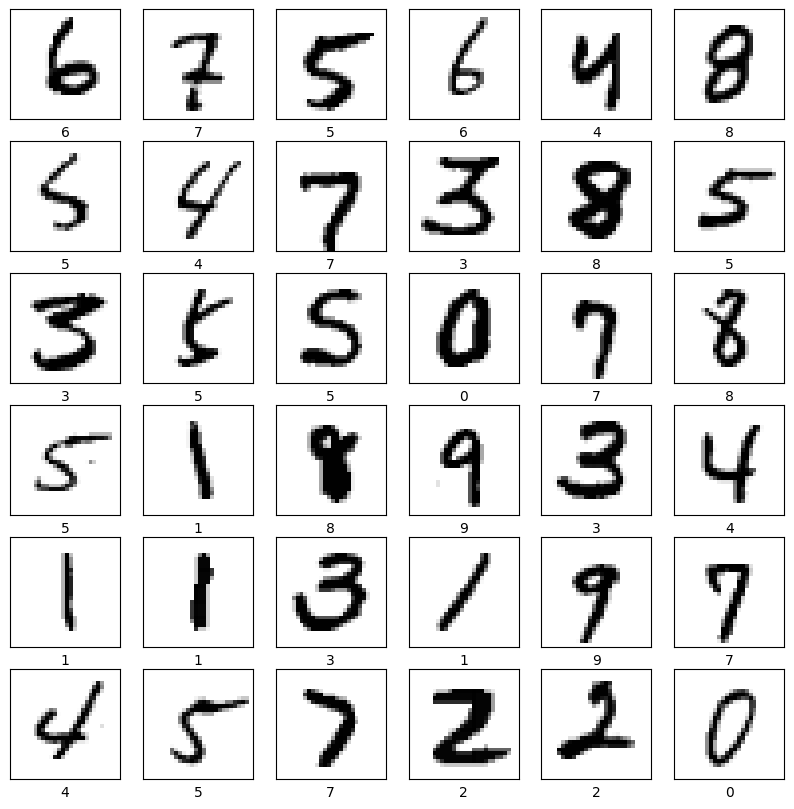

In [3]:
plt.figure(figsize=(10,10))
random_inds = np.random.choice(60000, 36)
for i in range(36):
    plt.subplot(6,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    image_ind = random_inds[i]
    plt.imshow(np.squeeze(train_images[image_ind]), cmap=plt.cm.binary)
    plt.xlabel(train_labels[image_ind])

## AutoEncoder
Stwórz model AutoEncodera. Użyj warst Dense. Wytrenuj i zwizualizuj odtworzone cyfry.

Epoch 1/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - Decoder_loss: 0.0758 - EncoderWithLabel_accuracy: 0.8269 - EncoderWithLabel_loss: 0.5407 - loss: 0.6165 - val_Decoder_loss: 0.0318 - val_EncoderWithLabel_accuracy: 0.9777 - val_EncoderWithLabel_loss: 0.0780 - val_loss: 0.1095
Epoch 2/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - Decoder_loss: 0.0303 - EncoderWithLabel_accuracy: 0.9794 - EncoderWithLabel_loss: 0.0700 - loss: 0.1002 - val_Decoder_loss: 0.0263 - val_EncoderWithLabel_accuracy: 0.9827 - val_EncoderWithLabel_loss: 0.0586 - val_loss: 0.0846
Epoch 3/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - Decoder_loss: 0.0262 - EncoderWithLabel_accuracy: 0.9871 - EncoderWithLabel_loss: 0.0428 - loss: 0.0690 - val_Decoder_loss: 0.0242 - val_EncoderWithLabel_accuracy: 0.9840 - val_EncoderWithLabel_loss: 0.0573 - val_loss: 0.0812
Epoch 4/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - Decoder_loss: 0.0244 - EncoderWithLabel_accuracy: 0.9915 - EncoderWithLabel_loss: 0.0273 - loss: 0.05

KeyError: 'LabelOutput_loss'

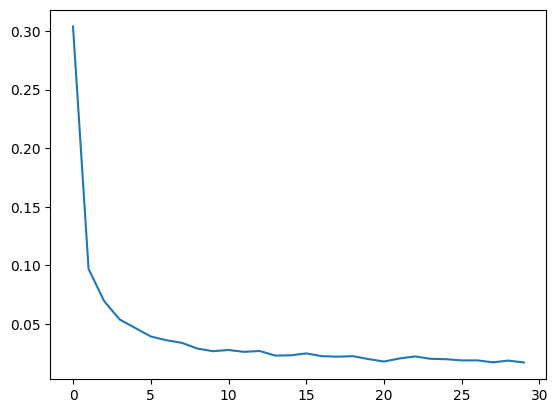

In [4]:
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape, Conv2D, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np

# Funkcja enkodera
def encoder_with_label(latent_dim, num_classes):
    # Wejście obrazu 28x28x1
    input_img = Input(shape=(28, 28, 1))
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = Flatten()(x)
    # Warstwa latentna
    latent = Dense(latent_dim, activation='relu')(x)
    # Wyjście klasyfikatora
    label_output = Dense(num_classes, activation='softmax', name="LabelOutput")(latent)
    return Model(inputs=input_img, outputs=[latent, label_output], name="EncoderWithLabel")

# Funkcja dekodera
def decoder(latent_dim):
    latent_input = Input(shape=(latent_dim,))
    x = Dense(7 * 7 * 64, activation='relu')(latent_input)
    x = Reshape((7, 7, 64))(x)
    x = Conv2DTranspose(64, (3, 3), activation='relu', strides=(2, 2), padding='same')(x) # Upsampling to 14x14
    x = Conv2DTranspose(32, (3, 3), activation='relu', strides=(2, 2), padding='same')(x) # Upsampling to 28x28
    decoded = Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same', name="ReconstructionOutput")(x)
    return Model(inputs=latent_input, outputs=decoded, name="Decoder")

# Ładowanie danych MNIST
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = np.expand_dims(x_train, axis=-1)  # Dodanie kanału
x_test = np.expand_dims(x_test, axis=-1)

# Parametry
latent_dim = 16
num_classes = 10

# Tworzenie modeli
enc = encoder_with_label(latent_dim, num_classes)
dec = decoder(latent_dim)

# Połączenie modeli w pełny autoenkoder
input_img = Input(shape=(28, 28, 1))
latent, label_output = enc(input_img)
reconstructed = dec(latent)
autoencoder = Model(inputs=input_img, outputs=[reconstructed, label_output], name="AutoencoderWithLabel")

# Kompilacja modelu
autoencoder.compile(
    optimizer='adam',
    loss=['mse', 'sparse_categorical_crossentropy'],  # Rekonstrukcja + Klasyfikacja
    metrics=[None, 'accuracy']  # Rekonstrukcja bez metryki, klasyfikacja z accuracy
    #OR
    metrics={'ReconstructionOutput': None, 'LabelOutput': 'accuracy'} #Using output layer names
)

# Kompilacja modelu
autoencoder.compile(
    optimizer='adam',
    loss=['mse', 'sparse_categorical_crossentropy'],  # Rekonstrukcja + Klasyfikacja
    # Use output layer names in metrics for clarity
    metrics=[None, 'accuracy']  #Instead of using dictionary-like metrics
)

# Train the model and store the training history
history = autoencoder.fit(
    x_train, [x_train, y_train],  # Input data and corresponding labels
    epochs=30,                  # Number of training epochs
    batch_size=128,             # Batch size for training
    validation_split=0.1        # Fraction of data used for validation
)



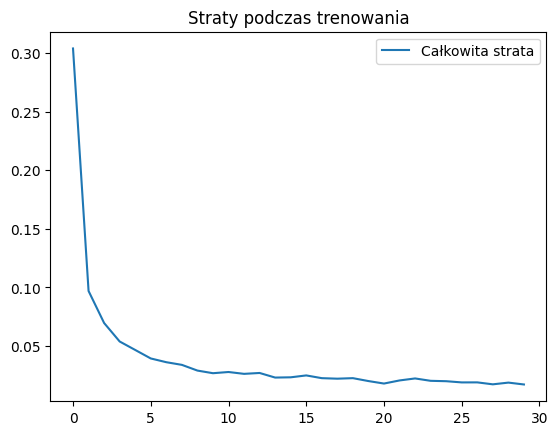

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 865ms/step


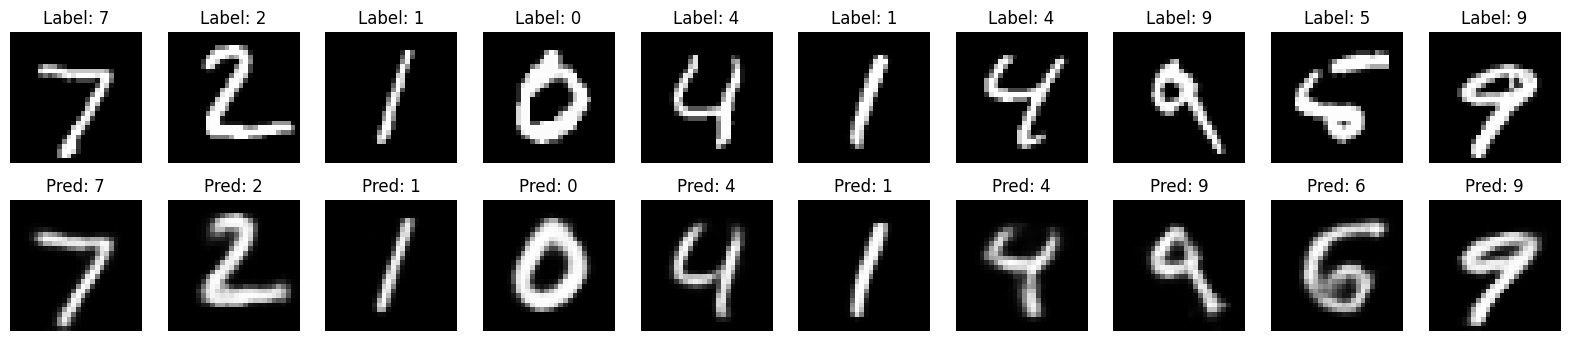

In [5]:

# Wizualizacja strat
plt.plot(history.history['loss'], label='Całkowita strata')
#plt.plot(history.history['ReconstructionOutput_loss'], label='Strata rekonstrukcji')
#plt.plot(history.history['LabelOutput_loss'], label='Strata klasyfikacji')
plt.legend()
plt.title("Straty podczas trenowania")
plt.show()

# Wizualizacja odtworzonych obrazów
n = 10
reconstructed, predicted_labels = autoencoder.predict(x_test[:n])

plt.figure(figsize=(20, 4))
for i in range(n):
    # Oryginalny obraz
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].squeeze(), cmap='gray')
    plt.title(f"Label: {y_test[i]}")
    plt.axis('off')

    # Odtworzony obraz
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed[i].squeeze(), cmap='gray')
    plt.title(f"Pred: {np.argmax(predicted_labels[i])}")
    plt.axis('off')

plt.show()

In [44]:
# model autoencodera i trenowanie
n = 1 # sprawdz działanie dla różnych wielkości przestrzeni latentnej
# enc = encoder(n) # Original line causing the error
enc = encoder_with_label(n, num_classes=10) # Use the correct function name and pass num_classes
dec = decoder(n)
# Instead of using Sequential, create a Functional model
input_img = Input(shape=(28, 28, 1))
latent, _ = enc(input_img)  # Get the latent representation, ignore the label output
reconstructed = dec(latent)  # Pass the latent representation to the decoder
ae_model = Model(inputs=input_img, outputs=reconstructed) # Create the autoencoder model

ae_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)          │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ EncoderWithLabel (Functional)        │ [(None, 1), (None, 10)]     │          69,013 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Decoder (Functional)                 │ (None, 28, 28, 1)           │          61,953 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 130,966 (511.59 KB)

 Trainable params: 130,966 (511.59 KB)

 Non-trainable params: 0 (0.00 B)

In [45]:
ae_model.compile(optimizer='adam', loss='mse')
ae_model.fit(train_images, train_images, epochs=30, batch_size=128, validation_split=0.1)

# uczenie z klasyfikatorem
#ae_model.compile(optimizer='adam', loss=['mse', 'sparse_categorical_crossentropy'], loss_weights=[0.4, 0.6], metrics=[None, 'accuracy'])
#ae_model.fit(train_images, [train_images, train_labels], epochs=30, batch_size=128, validation_split=0.1)

Epoch 1/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - loss: 0.1118 - val_loss: 0.0671
Epoch 2/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0674 - val_loss: 0.0671
Epoch 3/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0674 - val_loss: 0.0670
Epoch 4/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0674 - val_loss: 0.0671
Epoch 5/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0673 - val_loss: 0.0670
Epoch 6/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0673 - val_loss: 0.0671
Epoch 7/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0674 - val_loss: 0.0671
Epoch 8/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0673 - val_loss: 0.0670
Epoch 9/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0673 - val_loss: 0.0671
Epoch 10/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0672 - val_loss: 0.0671
Epoch 11/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0674 - val_loss: 0.0671
Epoch 12/30
422/422 ━━━━━━━━━━━━━━━━━━━━

In [35]:
# predykcja
imgs = train_images[:10]
pred = ae_model.predict(imgs)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step


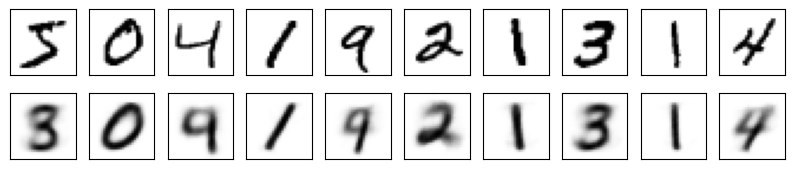

In [36]:
# wizualizacja
plt.figure(figsize=(10,2))
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(np.squeeze(imgs[i]), cmap=plt.cm.binary)
    plt.subplot(2, 10, i+1+10)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(np.squeeze(pred[i]), cmap=plt.cm.binary)
    #plt.xlabel(train_labels[image_ind])

In [37]:
# losowe wektory
ran = np.random.random((10,n))*2-1
ran

array([[-0.57814781,  0.73395795],
       [ 0.8338318 ,  0.26585881],
       [-0.41289866, -0.22992671],
       [ 0.29750564, -0.8688266 ],
       [ 0.68309037, -0.5248719 ],
       [-0.97971566,  0.93786899],
       [ 0.15736358,  0.39161866],
       [-0.74847764, -0.69169781],
       [-0.99856892, -0.99018404],
       [-0.78126864,  0.59485531]])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


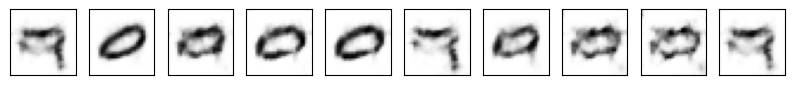

In [38]:
ran_imgs = dec.predict(ran)
plt.figure(figsize=(10,2))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(np.squeeze(ran_imgs[i]), cmap=plt.cm.binary)

## Wizualizacje przestrzeni ukrytej

In [39]:
latent = enc.predict(train_images)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


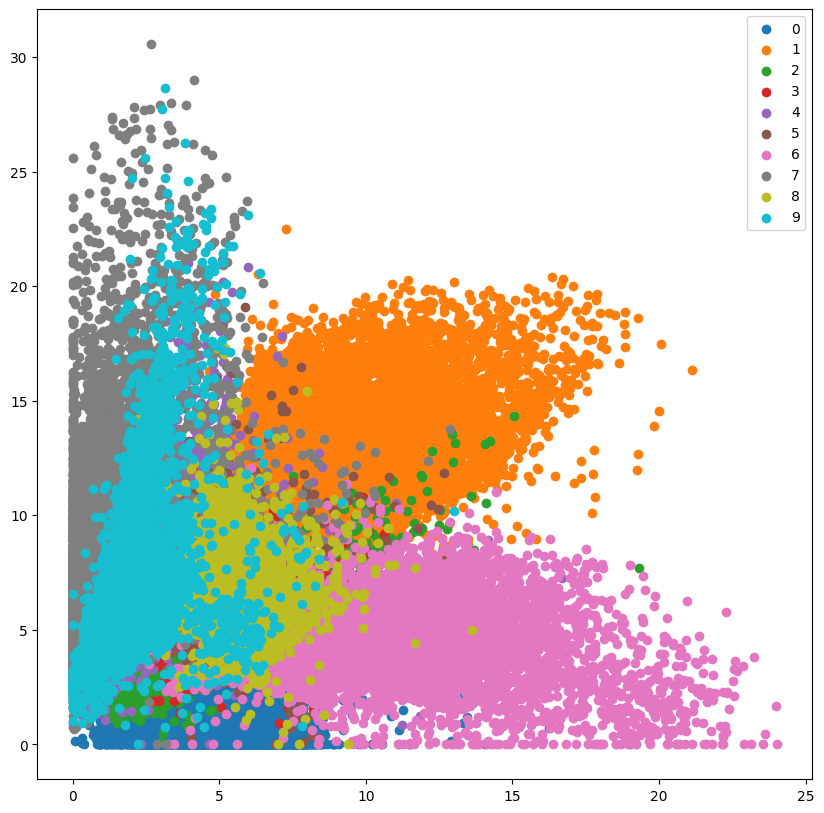

In [40]:
#wizualizacja
plt.figure(figsize=(10,10))
for i in range(10):
    # Access the first element of latent (the latent vectors)
    latent_vectors = latent[0]
    plt.scatter(latent_vectors[np.where(train_labels==i), 0], latent_vectors[np.where(train_labels==i), 1], label=str(i))
plt.legend()
plt.show()

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


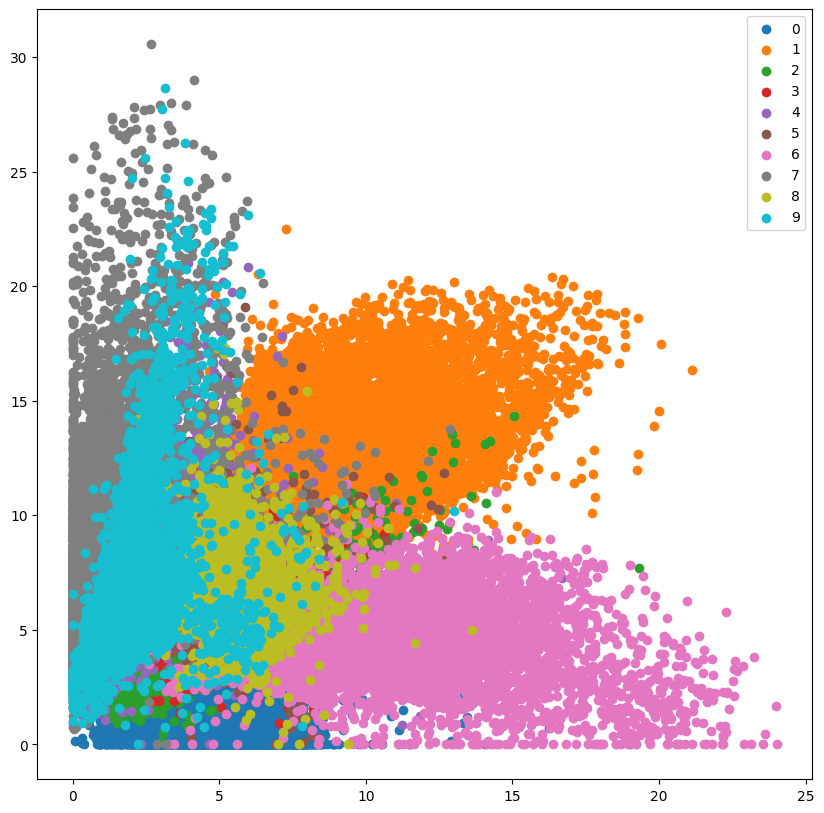

In [41]:
#wizualizacja wersja z klasyfikatorem
latent_vectors, _ = enc.predict(train_images)  # Unpack the output into latent_vectors and predicted_labels
plt.figure(figsize=(10,10))
for i in range(10):
    plt.scatter(latent_vectors[np.where(train_labels==i), 0], latent_vectors[np.where(train_labels==i), 1], label=str(i))
plt.legend()
plt.show()

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


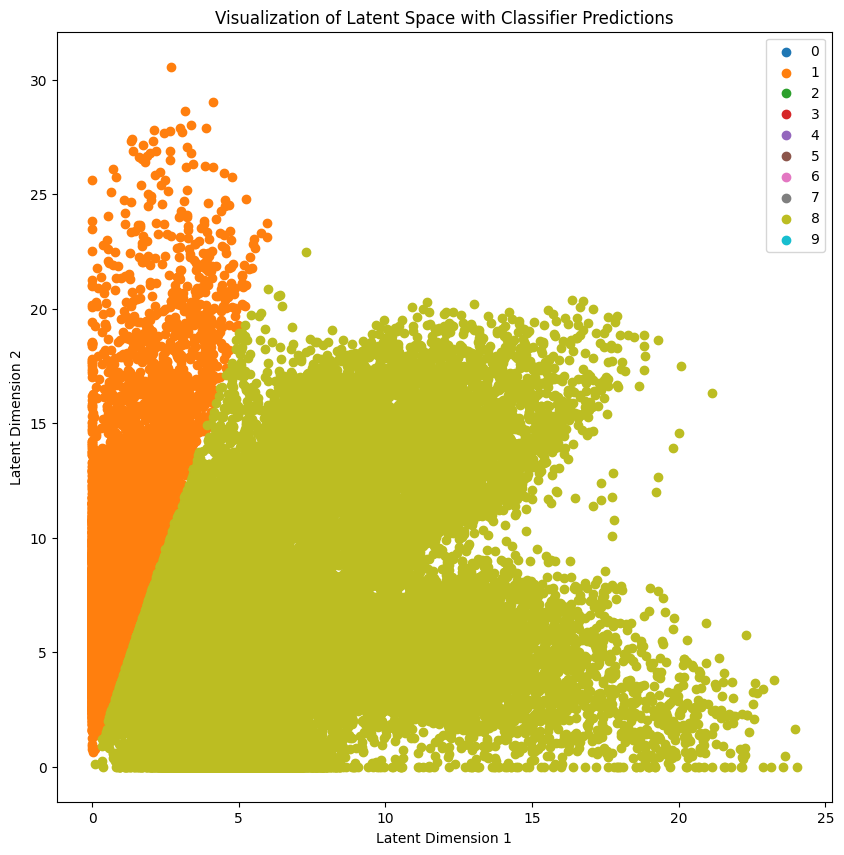

In [42]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'enc' is your encoder model, 'train_images' is your training data, and 'train_labels' are the true labels
latent_vectors, predicted_labels = enc.predict(train_images)  # Get both latent vectors and predicted labels

plt.figure(figsize=(10, 10))

# Iterate through each class (0-9)
for i in range(10):
    # Find indices of data points belonging to the current class, based on predicted labels
    indices = np.where(np.argmax(predicted_labels, axis=1) == i)

    # Plot these data points using their latent vectors for x and y coordinates
    plt.scatter(latent_vectors[indices, 0], latent_vectors[indices, 1], label=str(i))

plt.legend()
plt.title("Visualization of Latent Space with Classifier Predictions")
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.show()

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


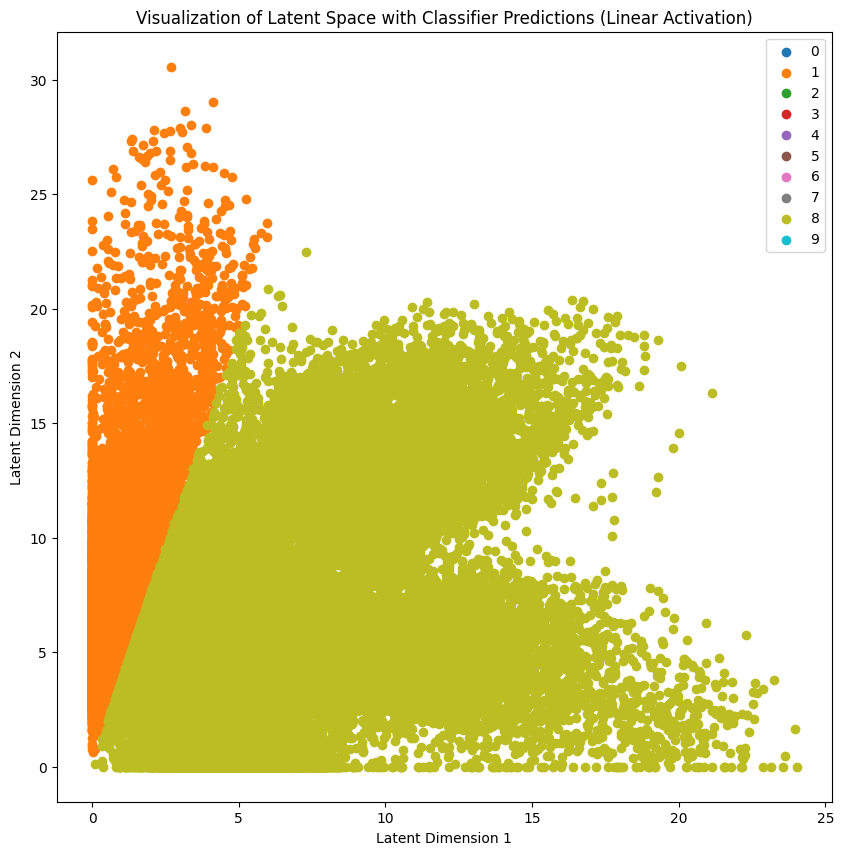

In [43]:
# wizualizacja, wersja z klasyfikatorem, funkcja linear zamiast tanh
import matplotlib.pyplot as plt
import numpy as np

latent_vectors, predicted_labels = enc.predict(train_images)  # Get both latent vectors and predicted labels

plt.figure(figsize=(10, 10))

for i in range(10):
    indices = np.where(np.argmax(predicted_labels, axis=1) == i)
    plt.scatter(latent_vectors[indices, 0], latent_vectors[indices, 1], label=str(i))

plt.legend()
plt.title("Visualization of Latent Space with Classifier Predictions (Linear Activation)")
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.show()

## Dodatkowe ćwiczenia
- Dokonaj redukcji wymiarowości innymi algorytmami np. PCA, i zwizualizuj
- Wygeneruj obrazy odtworzone z punktów leżących na okręgu o środku w (0,0), promień dobierz. Odpowienio dużo obrazów pokaże płynne przejścia pomiędzy klasami.
- Zdefiniuj enkoder i dekoder używając warst odpowiednio konwolucyjnych i dekonwolucyjnych. Porównaj wyniki.

Epoch 1/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - Decoder_loss: 0.0787 - EncoderWithLabel_accuracy: 0.8301 - EncoderWithLabel_loss: 0.5435 - loss: 0.6222 - val_Decoder_loss: 0.0372 - val_EncoderWithLabel_accuracy: 0.9777 - val_EncoderWithLabel_loss: nan - val_loss: nan
Epoch 2/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - Decoder_loss: 0.0356 - EncoderWithLabel_accuracy: 0.9805 - EncoderWithLabel_loss: 0.0643 - loss: 0.0999 - val_Decoder_loss: 0.0318 - val_EncoderWithLabel_accuracy: 0.9832 - val_EncoderWithLabel_loss: nan - val_loss: nan
Epoch 3/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - Decoder_loss: 0.0312 - EncoderWithLabel_accuracy: 0.9858 - EncoderWithLabel_loss: 0.0450 - loss: 0.0762 - val_Decoder_loss: 0.0293 - val_EncoderWithLabel_accuracy: 0.9857 - val_EncoderWithLabel_loss: nan - val_loss: nan
Epoch 4/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - Decoder_loss: 0.0288 - EncoderWithLabel_accuracy: 0.9915 - EncoderWithLabel_loss: 0.0281 - loss: 0.0569 - val_Decoder_

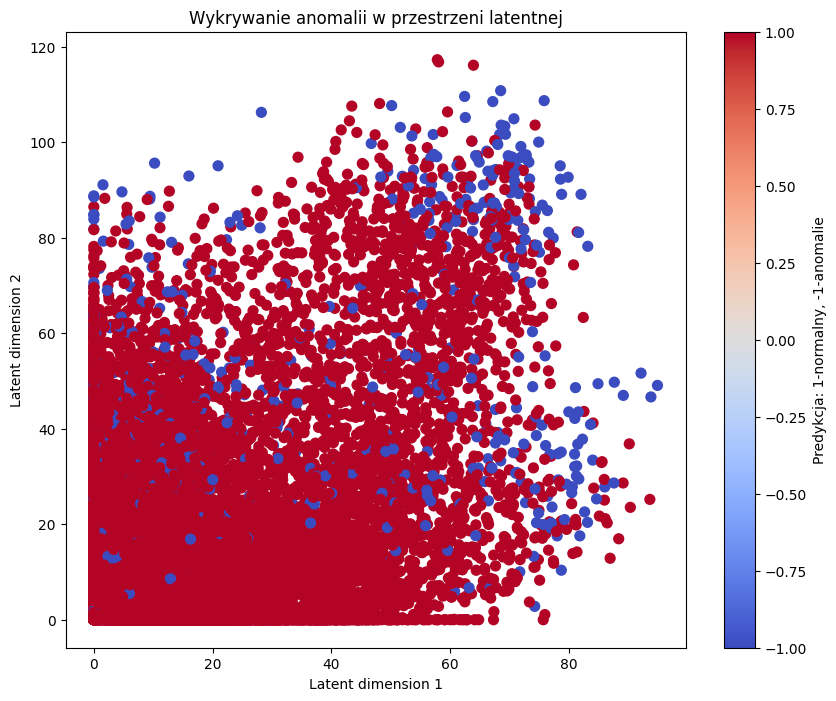

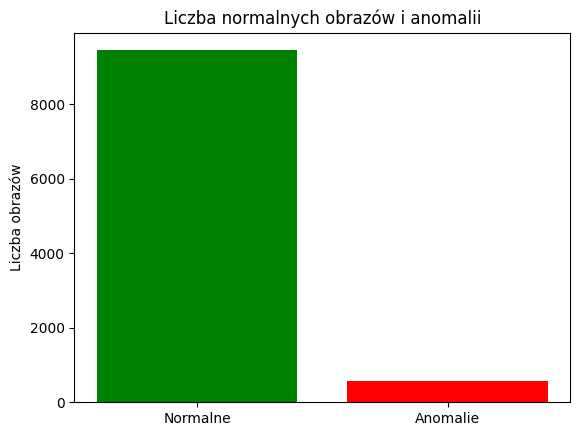

In [32]:
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape, Conv2D, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import IsolationForest

# Funkcja enkodera
def encoder_with_label(latent_dim, num_classes):
    input_img = Input(shape=(28, 28, 1))
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = Flatten()(x)
    latent = Dense(latent_dim, activation='relu')(x)
    label_output = Dense(num_classes, activation='softmax', name="LabelOutput")(latent)
    return Model(inputs=input_img, outputs=[latent, label_output], name="EncoderWithLabel")

# Funkcja dekodera
def decoder(latent_dim):
    latent_input = Input(shape=(latent_dim,))
    x = Dense(7 * 7 * 64, activation='relu')(latent_input)
    x = Reshape((7, 7, 64))(x)
    x = Conv2DTranspose(64, (3, 3), activation='relu', strides=(2, 2), padding='same')(x)  # Upsampling to 14x14
    x = Conv2DTranspose(32, (3, 3), activation='relu', strides=(2, 2), padding='same')(x)  # Upsampling to 28x28
    decoded = Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same', name="ReconstructionOutput")(x)
    return Model(inputs=latent_input, outputs=decoded, name="Decoder")

# Ładowanie danych MNIST
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = np.expand_dims(x_train, axis=-1)  # Dodanie kanału
x_test = np.expand_dims(x_test, axis=-1)

# Parametry
latent_dim = 16
num_classes = 10

# Tworzenie modeli
enc = encoder_with_label(latent_dim, num_classes)
dec = decoder(latent_dim)

# Połączenie modeli w pełny autoenkoder
input_img = Input(shape=(28, 28, 1))
latent, label_output = enc(input_img)
reconstructed = dec(latent)
autoencoder = Model(inputs=input_img, outputs=[reconstructed, label_output], name="AutoencoderWithLabel")

# Kompilacja modelu
autoencoder.compile(
    optimizer='adam',
    loss=['mse', 'sparse_categorical_crossentropy'],  # Rekonstrukcja + Klasyfikacja
    metrics=[None, 'accuracy']  # Rekonstrukcja bez metryki, klasyfikacja z accuracy
)

# 1. Generowanie niestandardowego obrazu (np. losowy szum)
anomaly_image = np.random.rand(28, 28, 1)  # Szum o wymiarach 28x28x1

# Dodanie go do zbioru treningowego
x_train_with_anomaly = np.concatenate([x_train, anomaly_image.reshape(1, 28, 28, 1)], axis=0)
y_train_with_anomaly = np.concatenate([y_train, np.array([10])], axis=0)  # Oznaczenie jako "klasa 10" (nieistniejąca)

# Trening modelu na danych z anomalią
history = autoencoder.fit(
    x_train_with_anomaly, [x_train_with_anomaly, y_train_with_anomaly],
    epochs=30,
    batch_size=128,
    validation_split=0.1
)


# 2. Wykorzystanie przestrzeni latentnej do wykrywania anomalii
latent_representations = enc.predict(x_train_with_anomaly)[0]  # Uzyskiwanie reprezentacji latentnej dla danych treningowych

# Trenowanie modelu Isolation Forest na przestrzeni latentnej
iso_forest = IsolationForest(contamination=0.05)  # Przyjmujemy, że 5% danych to anomalie
iso_forest.fit(latent_representations)

# Predykcja anomalii na zbiorze testowym
latent_test = enc.predict(x_test)[0]  # Uzyskiwanie reprezentacji latentnej dla danych testowych
predicted_anomalies = iso_forest.predict(latent_test)  # -1 oznacza anomalię, 1 normalny

# Wizualizacja wyników detekcji anomalii w postaci wykresu:
anomaly_count = np.sum(predicted_anomalies == -1)  # Liczba anomalii
normal_count = np.sum(predicted_anomalies == 1)    # Liczba normalnych obrazów

# Wykres rozkładu detekcji anomalii w przestrzeni latentnej
plt.figure(figsize=(10, 8))

# Kolorowanie wyników: anomalie - czerwony, normalne - niebieski
plt.scatter(latent_test[:, 0], latent_test[:, 1], c=predicted_anomalies, cmap='coolwarm', s=50)
plt.title('Wykrywanie anomalii w przestrzeni latentnej')
plt.xlabel('Latent dimension 1')
plt.ylabel('Latent dimension 2')
plt.colorbar(label='Predykcja: 1-normalny, -1-anomalie')
plt.show()

# Wizualizacja wyników detekcji anomalii w postaci wykresu słupkowego
labels = ['Normalne', 'Anomalie']
counts = [normal_count, anomaly_count]

plt.bar(labels, counts, color=['green', 'red'])
plt.title('Liczba normalnych obrazów i anomalii')
plt.ylabel('Liczba obrazów')
plt.show()